In [71]:
# import libraries
import numpy as np
import pandas as pd
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

import seaborn as sns
import re
import string
from nltk.stem.snowball import SnowballStemmer

from IPython.display import display_html
def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)
    
!pip install nlppreprocess
from nlppreprocess import NLP

nlp = NLP()

You should consider upgrading via the 'pip install --upgrade pip' command.


In [72]:
# datasets
train_df = pd.read_csv('input/train.csv')
test_df = pd.read_csv('input/test.csv')
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
# example of a non-disaster tweet
train_df[train_df["target"] == 0]["text"].values[0]

"What's up man?"

In [4]:
# example of a disaster tweet
train_df[train_df["target"] == 1]["text"].values[0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

In [61]:
# look at missing values of each variable
train_perc_missing = train_df.isnull().mean()*100
test_perc_missing = test_df.isnull().mean()*100

df1 = pd.DataFrame({'Train Missing Percentage': train_perc_missing.sort_values(ascending=False)})
df2 = pd.DataFrame({'Test Missing Percentage': test_perc_missing.sort_values(ascending=False)})
display_side_by_side(df1,df2)

,Train Missing Percentage
location,33.272035
keyword,0.801261
target,0.000000
text,0.000000
id,0.000000
,Test Missing Percentage
location,33.864542
keyword,0.796813
text,0.000000
id,0.000000


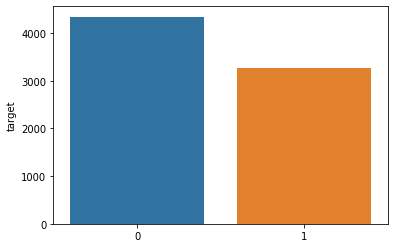

In [62]:
# look at distribution of disaster / non-disaster tweets
sns.barplot(train_df['target'].value_counts().index, train_df['target'].value_counts())


In [73]:
# text preprocessing - lowercase everything
def lowercase_text(text):
    text = text.lower()
    return text

train_df['text'] = train_df['text'].apply(lambda x: lowercase_text(x))
test_df['text'] = test_df['text'].apply(lambda x: lowercase_text(x))

In [74]:
# text preprocessing - removing text noise

def remove_noise(text):
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

train_df['text'] = train_df['text'].apply(lambda x: remove_noise(x))
test_df['text'] = test_df['text'].apply(lambda x: remove_noise(x))

In [75]:
# text preprocessing - remove stopwords

train_df['text'] = train_df['text'].apply(nlp.process)
test_df['text'] = test_df['text'].apply(nlp.process)  

In [25]:
# text preprocessing - stemming (removing everything but root word)

stemmer = SnowballStemmer("english")

def stemming(text):
    text = [stemmer.stem(word) for word in text.split()]
    return ' '.join(text)

train_df['text'] = train_df['text'].apply(stemming)
test_df['text'] = test_df['text'].apply(stemming)

In [76]:
# text preprocessing - others
def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

def remove_punct(text):
    table=str.maketrans('','',string.punctuation)
    return text.translate(table)

train_df['text'] = train_df['text'].apply(lambda x : remove_html(x))
test_df['text'] = test_df['text'].apply(lambda x : remove_html(x))

train_df['text'] = train_df['text'].apply(lambda x : remove_emoji(x))
test_df['text'] = test_df['text'].apply(lambda x : remove_emoji(x))

train_df['text'] = train_df['text'].apply(lambda x : remove_punct(x))
test_df['text'] = test_df['text'].apply(lambda x : remove_punct(x))


In [77]:
count_vectorizer = feature_extraction.text.CountVectorizer()

# we can look at the first 5 tweets in the data and get counts for them
example_train_vectors = count_vectorizer.fit_transform(train_df["text"][0:5])

In [51]:
# there are 54 unique words (or tokens) in the first 5 tweets
print(example_train_vectors[0].todense().shape)
# the first tweet contains only some of those unique tokens
print(example_train_vectors[0].todense())
# remaining questions, what are the rest of the components of example_train_vectors?

(1, 52)
[[0 1 1 1 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0
  0 1 0 0 0 0 0 0 0 0 0 1 1 0 1 0]]


In [78]:
# now we can create vectors for all of our tweets
train_vectors = count_vectorizer.fit_transform(train_df["text"])

test_vectors = count_vectorizer.transform(test_df["text"])
#remaining questions, why use .transform vs .fit_transform

In [79]:
# using TFIDF
tfidf = feature_extraction.text.TfidfVectorizer(min_df=2, max_df=0.5, ngram_range=(1,2))


tfidf.fit(train_df['text'])
train_tfidf = tfidf.fit_transform(train_df['text'])
test_tfidf = tfidf.transform(test_df['text'])

In [80]:
# use ridge regression in order to push model weights to 0 without
# completely discounting different words -- look further into this
clf_RR = RidgeClassifier()

# let's test our model to see how well it does on training data
# we can do this by cross validation (train portion of training data & validate with rest)

# metric for this competition is F1
# look further into the function cross_val_score & its outputs

cv_scores = model_selection.cross_val_score(clf_RR, train_vectors, train_df["target"], cv=3, scoring='f1')
print(cv_scores)

tf_scores = model_selection.cross_val_score(clf_RR, train_tfidf, train_df["target"], cv=3, scoring='f1')
print(tf_scores)

[0.62201454 0.55165692 0.63259402]
[0.62057522 0.56656347 0.62712739]


In [81]:
# try using logistic regression instead
clf_LogR = LogisticRegression(C=1.0)
cv_scores = model_selection.cross_val_score(clf_LogR, train_vectors, train_df["target"], cv=5, scoring="f1")
print(cv_scores)

tf_scores = model_selection.cross_val_score(clf_LogR, train_tfidf, train_df["target"], cv=5, scoring="f1")
print(tf_scores)

/Users/Jenny/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0.62184874 0.54421769 0.60411523 0.58034894 0.71742543]
[0.6035503  0.53507951 0.58076225 0.56868396 0.70389171]


/Users/Jenny/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [82]:
# try using Naive Bayes
clf_NB = MultinomialNB()
cv_scores = model_selection.cross_val_score(clf_NB, train_vectors, train_df["target"], cv=5, scoring="f1")
print(cv_scores)

tf_scores = model_selection.cross_val_score(clf_NB, train_tfidf, train_df["target"], cv=5, scoring="f1")
print(tf_scores)


[0.65937763 0.6250928  0.68995633 0.64686998 0.73991655]
[0.59528487 0.56424079 0.62842012 0.59606373 0.74679487]


In [83]:
# time to do predictions on training set and build submission
# clf_RR.fit(train_vectors, train_df["target"])
clf_LogR.fit(train_tfidf, train_df["target"])
#clf_NB.fit(train_tfidf, train_df["target"])

/Users/Jenny/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [84]:
sample_submission = pd.read_csv("input/sample_submission.csv")

In [85]:
sample_submission["target"] = clf_LogR.predict(test_tfidf)

In [86]:
sample_submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1


In [87]:
sample_submission.to_csv("submission.csv", index=False)